In [55]:
import collections
import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch 
import torch.nn as nn
import torch.optim as optim
import torchtext
import tqdm
import transformers

In [56]:
seed=1234

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic=True

In [57]:
train_data,test_data=datasets.load_dataset("imdb",split=["train","test"])

In [58]:
transformer_name="bert-base-uncased"
tokenizer=transformers.AutoTokenizer.from_pretrained(transformer_name)

tokenlestirme-> cumleyi kelimelere yada harflere yada alt cumlelere ayirir.

In [59]:
tokenizer.tokenize("hello world!")

['hello', 'world', '!']

Kodlama-> olusturulan tokenlara essiz token id'ler atayarak modelin anlamasini kolaylastirir.


In [60]:
tokenizer.encode("hello world!") 

[101, 7592, 2088, 999, 102]

Olusturulan token id'leri tekrardan onlarin temsil ettigi tokenlara geri cevirir bu arada modelin yapacagi islemi daha iyi kavramasi icin cumle sonuna ve basina bazi belirtecler koyar.

[CLS]->Siniflandirma(classification) problemi oldugunu belirtir.
[SEP]->Cumlenin artik bittigini veyahut arkasindan gelen cumleden ayrildigini belirtmek icin kullanilir.

In [61]:
tokenizer.convert_ids_to_tokens(tokenizer.encode("hello world!")) 

['[CLS]', 'hello', 'world', '!', '[SEP]']

In [62]:
tokenizer("hello world!")

{'input_ids': [101, 7592, 2088, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1]}

Bu fonksiyon girdi olarak text alir ve bize tokenlari ile birlikte bir sozluk dondurur.


In [63]:
def tokenize_and_numericalize_example(example,tokenizer):
    ids=tokenizer(example["text"],truncation=True)["input_ids"]
    return {"ids":ids}

tokenize_and_numericalize_example fonksiyonunun islevini datasetteki tum elementlere uygulayip train_data ve test_data degiskenlerine atar

In [64]:
train_data=train_data.map(
tokenize_and_numericalize_example,fn_kwargs={"tokenizer":tokenizer})
test_data=test_data.map(
tokenize_and_numericalize_example,fn_kwargs={"tokenizer":tokenizer})

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [65]:
train_data[1]

{'text': '"I Am Curious: Yellow" is a risible and pretentious steaming pile. It doesn\'t matter what one\'s political views are because this film can hardly be taken seriously on any level. As for the claim that frontal male nudity is an automatic NC-17, that isn\'t true. I\'ve seen R-rated films with male nudity. Granted, they only offer some fleeting views, but where are the R-rated films with gaping vulvas and flapping labia? Nowhere, because they don\'t exist. The same goes for those crappy cable shows: schlongs swinging in the breeze but not a clitoris in sight. And those pretentious indie movies like The Brown Bunny, in which we\'re treated to the site of Vincent Gallo\'s throbbing johnson, but not a trace of pink visible on Chloe Sevigny. Before crying (or implying) "double-standard" in matters of nudity, the mentally obtuse should take into account one unavoidably obvious anatomical difference between men and women: there are no genitals on display when actresses appears nude, 

tokenlestirme sirasinda dizilerin esit uzunlukta olmasi icin ozel bir [PAD] adinda token ekler

In [66]:
tokenizer.pad_token

'[PAD]'

In [67]:
pad_index = tokenizer.pad_token_id

Burada datasetimizi %80 oraninda training, %20 oraninda test, datasi olacak sekilde ayırma islemi yapilip ilgili degiskenlere atilmaktadir.

In [68]:
test_size=0.2
train_valid_data=train_data.train_test_split(test_size=test_size)
train_data=train_valid_data["train"]
valid_data=train_valid_data["test"]

Pytorch formatina uygun olamasi icin train,test ve validation datasetleri ayarlaniyor

In [69]:
train_data=train_data.with_format(type="torch",columns=["ids","label"])
valid_data=valid_data.with_format(type="torch",columns=["ids","label"])
test_data=test_data.with_format(type="torch",columns=["ids","label"])


Modele aktarilmadan once bir grup ornegi isler
pad_index->batching sirasinda giris dizilerini sabit uzunluga getirir.
batch_ids->tokenlarin id'lerini bir listede tutar.
nn.utils.rnn.pad_sequence->batchteki dizileri aynı uzunluga pad_index tarafindan belirtilen padding_value ile ayni uzunluga getirir. batch_first-> batch boyutunun cikti boyutunun ilk boyutu oldugunu belirtir.
batch_label->batchteki her bir ornegin etiketini torch.stack kullanarak yıgar.
batch->bir sozluktur. id'leri ve etiketlerini icerir.collate fonksiyonunun ciktisini dondurur. 



In [70]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids=[i["ids"] for i in batch]
        batch_ids=nn.utils.rnn.pad_sequence(batch_ids,padding_value=pad_index,batch_first=True)
        
        batch_label=[i["label"] for i in batch]
        batch_label=torch.stack(batch_label)
        batch={"ids":batch_ids,"label":batch_label}
        return batch
    
    return collate_fn
        
        

torch.utils.data.DataLoader-> bir pytorch veriyukleme objesi olusturur.
modeli eğiteceğimiz,doğrulayacağımız ve test edeceğimiz veriyukleme objesinini olusturan fonksiyondur.


In [71]:
def get_data_loader(dataset,batch_size,pad_index,shuffle=False):
    collate_fn=get_collate_fn(pad_index)
    data_loader=torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=shuffle
    )
    return data_loader

In [72]:
batch_size=8

train_data_loader=get_data_loader(train_data,batch_size,pad_index,shuffle=True)
valid_data_loader=get_data_loader(valid_data,batch_size,pad_index)
test_data_loader=get_data_loader(test_data,batch_size,pad_index)

Transformers modelini kullanarak bu modelin son katmanı üzerinden tahmin yapar.

In [73]:
class Transformer(nn.Module):
    def __init__(self,transformer,output_dim,freeze):
        super().__init__()
        self.transformer=transformer
        hidden_dim=transformer.config.hidden_size
        self.fc=nn.Linear(hidden_dim,output_dim)
        if freeze:
            for param in self.transformer.parameters():
                param.requires_grad=False
    def forward(self,ids):
        #ids=[batch size,seq len]
        output=self.transformer(ids,output_attentions=True)
        #hidden=[batch size,seq len,hidden dim]
        hidden=output.last_hidden_state
        #attention=[batch size,n heads, seq len, seq len]
        attention=output.attentions[-1]
        cls_hidden=hidden[:,0,:]
        #prediction=[batch size,output dim] 
        prediction=self.fc(torch.tanh(cls_hidden))
        
        return prediction
        
        

In [74]:
transformer=transformers.AutoModel.from_pretrained(transformer_name)

In [75]:
transformer.config.hidden_size

768

output_dim-kac adet label oldugunu hesaplayarak model icin cikti boyutunu verir.
'freeze'-> transformer mimarisininin training sirasinda dondurulup dondurulmaaycagini belirtir.
model->transformer sinifindan bir ornek olusturur.


In [76]:
output_dim=len(train_data["label"].unique())
freeze=False

model=Transformer(transformer,output_dim,freeze)

Bir pytorch modelinde toplamm kac tane egitilebilir parametre oldugunu hesaplar

In [77]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters () if p.requires_grad)


print(f"The model has {count_parameters(model):,}trainable parameters")

The model has 109,483,778trainable parameters


AdamOptimizer->geri yayilim boyunca gradyan hesaplamalarina dayanan parametreleri guncelliyecektir

In [78]:
lr=5e-5 #0.00005 
optimizer=optim.Adam(model.parameters(),lr=lr)

CrossEntropy->modelin tahminleri ile gercek etiket degerleri arasindaki kaybi hesaplar

In [79]:
criterion=nn.CrossEntropyLoss()

In [80]:
device=torch.device("cuda" if torch.cuda.is_available() else"cpu")
device

device(type='cuda')

In [81]:
model=model.to(device)
criterion=criterion.to(device)

Modeli egitmek icin kullanilan fonskiyondur.

In [82]:
def train(data_loader,model,criterion,optimizer,device):
    model.train()
    epoch_losses=[]
    epoch_accs=[]
    for batch in tqdm.tqdm(data_loader,desc="training..."):
        ids=batch["ids"].to(device)
        label=batch["label"].to(device)
        prediction=model(ids)
        loss=criterion(prediction,label)
        accuracy=get_accuracy(prediction,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses),np.mean(epoch_accs)

Modelin basarisini degerlendirmek icin kullanilan fonksiyondur

In [83]:
def evaluate(data_loader,model,criterion,device):
    model.eval()
    epoch_losses=[]
    epoch_accs=[]
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader,desc="evaluating..."):
            ids=batch["ids"].to(device)
            label=batch["label"].to(device)
            prediction=model(ids)
            loss=criterion(prediction,label)
            accuracy=get_accuracy(prediction,label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses),np.mean(epoch_accs)

Modelin dogruluk oranini gostermek icin kullanilan fonksiyondur

In [84]:
def get_accuracy(prediction,label):
    batch_size,_=prediction.shape
    predicted_classes=prediction.argmax(dim=-1)
    correct_predictions=predicted_classes.eq(label).sum()
    accuracy=correct_predictions/batch_size
    return accuracy

Modeli egittimiz yerdir ve egitim sonunda bze egitim ve dogrulama oranlarini dondurur

In [85]:
n_epochs=2
best_valid_loss=float("inf")

metrics=collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss,train_acc=train(
        train_data_loader,model,criterion,optimizer,device
    )
    valid_loss,valid_acc=evaluate(valid_data_loader,model,criterion,device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)    
    metrics["valid_accs"].append(valid_acc)
    if valid_loss<best_valid_loss:
        best_valid_loss=valid_loss
        torch.save(model.state_dict(),"transformer.pt")
    print(f"epoch:{epoch}")
    print(f"train_loss:{train_loss:.3f},train_acc:{train_acc:.3f}")
    print(f"valid_loss:{valid_loss:.3f},valid_acc:{valid_acc:.3f}")

evaluating...: 100%|██████████| 625/625 [01:20<00:00,  7.77it/s]


epoch:0
train_loss:0.281,train_acc:0.885
valid_loss:0.216,valid_acc:0.914


evaluating...: 100%|██████████| 625/625 [01:20<00:00,  7.81it/s]


epoch:1
train_loss:0.170,train_acc:0.938
valid_loss:0.200,valid_acc:0.920


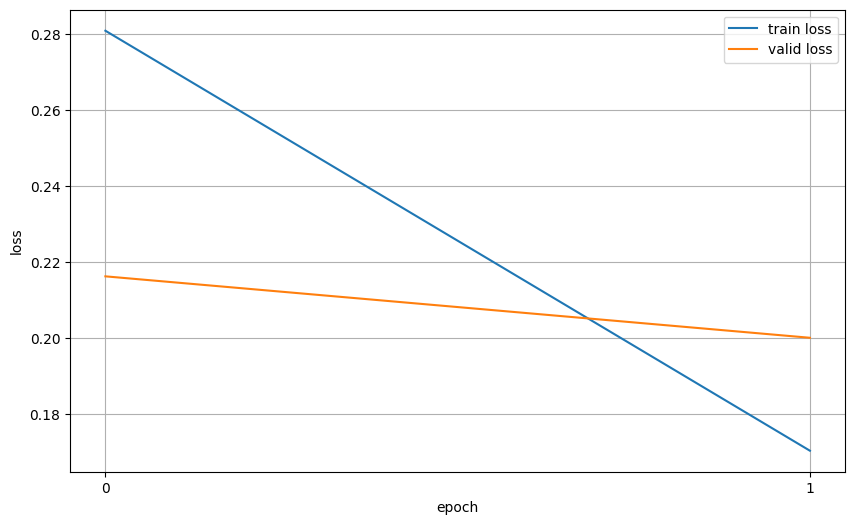

In [86]:
fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(1,1,1)
ax.plot(metrics["train_losses"],label="train loss")
ax.plot(metrics["valid_losses"],label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

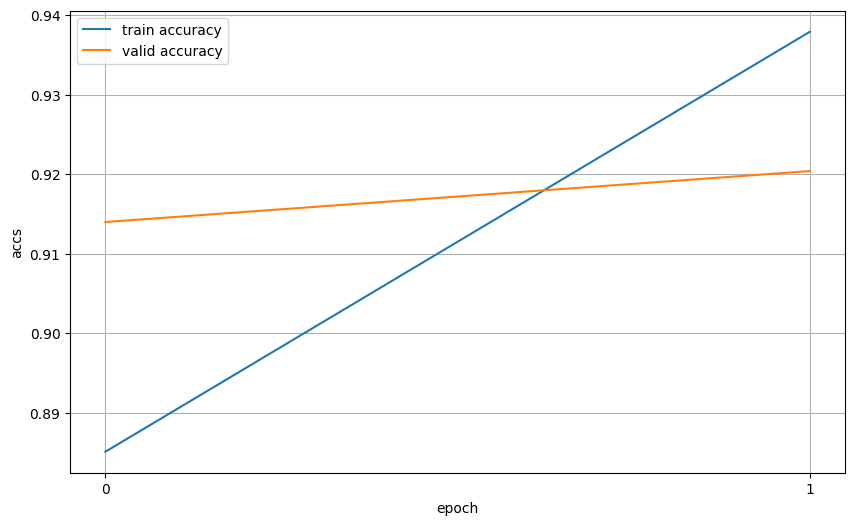

In [87]:
fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(1,1,1)
ax.plot(metrics["train_accs"],label="train accuracy")
ax.plot(metrics["valid_accs"],label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("accs")
ax.set_xticks((range(n_epochs)))
ax.legend()
ax.grid()


In [88]:
model.load_state_dict(torch.load("transformer.pt"))
test_loss,test_acc=evaluate(test_data_loader,model,criterion,device)

evaluating...: 100%|██████████| 3125/3125 [06:30<00:00,  8.01it/s]


In [89]:
print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")


test_loss: 0.194, test_acc: 0.923


Duygu analizi tahminini yapan fonksiyondur.

In [90]:
def predict_sentiment(text,model,tokenizer,device):
    ids=tokenizer(text)["input_ids"]
    tensor=torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction=model(tensor).squeeze(dim=0)
    probability=torch.softmax(prediction,dim=-1)
    predicted_class=prediction.argmax(dim=-1).item()
    predicted_probability=probability[predicted_class].item()
    return predicted_class,predicted_probability

Verilen datasetteki bilgilere göre duygu analizi yapan fonksiyondur

In [91]:
def predict_dataset_sentiments(dataset,model,tokenizer,device):
    print(f"{'Review':<50}|{'Predicted Sentiment':<20}|{'Probability':<10}")
    print("-"*90)
    
    class_labels={0:"negative",1:"positive"}
    
    for index,row in dataset.iterrows():
        text=row['review']
        predicted_class,predicted_probability=predict_sentiment(text,model,tokenizer,device)
        predicted_label=class_labels[predicted_class]
        
        print(f"\n\n\n{text:<50}|\n\n\n{predicted_label:<20}|{predicted_probability:.3f}")

In [95]:
train_dataset_v2=datasets.load_dataset("damerajee/IMDB-sentiment-reviews",split="train")
    
dataset_for_p=train_dataset_v2.select(range(10))

small_dataset_for_p=dataset_for_p.to_pandas()

    

In [96]:
print(small_dataset_for_p.head(10))

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
5  Probably my all-time favorite movie, a story o...  positive
6  I sure would like to see a resurrection of a u...  positive
7  This show was an amazing, fresh & innovative i...  negative
8  Encouraged by the positive comments about this...  negative
9  If you like original gut wrenching laughter yo...  positive


Uygulama için verilen datasetteki text alanları modele verilerek tahmin yaptırılmıştır.

In [97]:
predict_dataset_sentiments(small_dataset_for_p,model,tokenizer,device)

Review                                            |Predicted Sentiment |Probability
------------------------------------------------------------------------------------------



One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, I